# Generating Simulated Data for Prevalence Estimation Tasks

We will generate six datasets, all under the `data` folder.

* `dataset1_base`: Extrinsic labels with a good classifier
* `dataset1_target`: Extrinsic labels with a good classifier
* `dataset2_base`: Extrinsic labels with a bad classifier
* `dataset2_target`: Extrinsic labels with a bad classifier
* `dataset3_base`: Extrinsic labels with mixed subgroups (a good classifier and a bad classifier)
* `dataset3_target`: Extrinsic labels with mixed subgroups (a good classifier and a bad classifier)
* `dataset4_base`: Intrinsic labels with a good classifier
* `dataset4_target`: Intrinsic labels with a good classifier
* `dataset5_base`: Intrinsic labels with a bad classifier
* `dataset5_target`: Intrinsic labels with a bad classifier
* `dataset6_base`: Intrinsic labels with mixed subgroups (a good classifier and a bad classifier)
* `dataset6_target`: Intrinsic labels with mixed subgroups (a good classifier and a bad classifier)

### Data Format

|        | pos | neg | gender |   age |
|--------|-----|-----|--------|-------|
| item 1 | 0.2 | 0.8 | female | young |
| item 2 | 0.3 | 0.7 | female |   old |
|        |     |     |        |       |
| item n | 0.9 | 0.1 |   male |   old |

In [1]:
import sys, json
from os.path import dirname, abspath

sys.path.append(dirname(abspath('')))

In [2]:
from scipy.stats import beta, uniform
from pyquantifier.plot import *
from pyquantifier.distributions import MixtureCUD, IntrinsicJointDistribution, MultinomialDUD, ExtrinsicJointDistribution
from pyquantifier.calibration_curve import PlattScaling

## Intrinsic Joint Distribution

In [3]:
labels = ['neg', 'pos']

pos_cud = MixtureCUD(components=[beta(10, 2), uniform(0, 1)], weights=[0.99, 0.01])
neg_cud = MixtureCUD(components=[beta(2, 5), uniform(0, 1)], weights=[0.95, 0.05])
class_conditional_densities = {'pos': pos_cud, 'neg': neg_cud}

label_distribution = MultinomialDUD(labels, [0.8, 0.2])

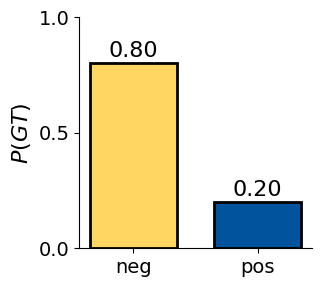

In [4]:
label_distribution.plot()

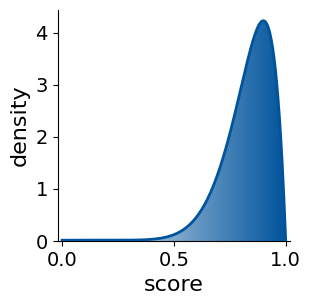

In [5]:
class_conditional_densities['pos'].plot(color=ColorPalette.pos_color)

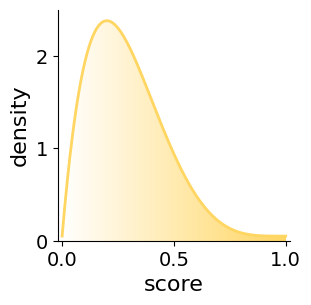

In [6]:
class_conditional_densities['neg'].plot(color=ColorPalette.neg_color)

In [7]:
intrinsic_joint_distribution = IntrinsicJointDistribution(labels, label_distribution, class_conditional_densities)

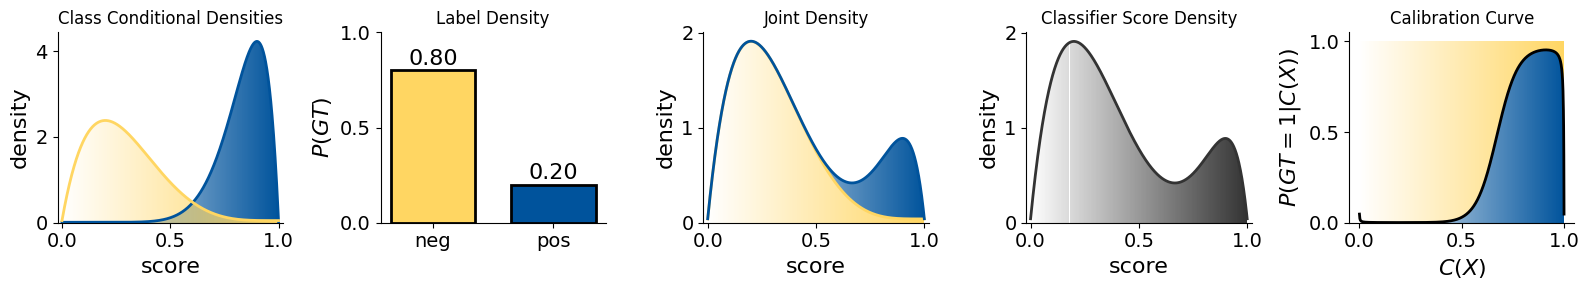

In [8]:
intrinsic_joint_distribution.plot_five_distributions(num_bin=1000)

## Extrinsic Joint Distribution

In [9]:
labels = ['pos', 'neg']
classifier_score_distribution = MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[2, 8])

w = 21.92
b = -14.61
calibration_curve = PlattScaling()
calibration_curve.set_params(w, b)

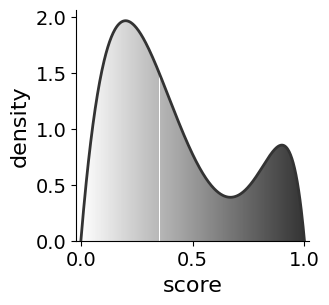

In [10]:
classifier_score_distribution.plot()

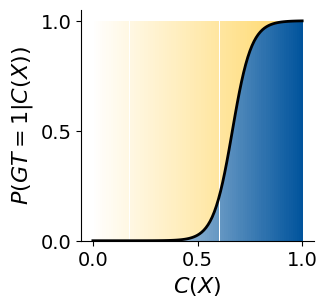

In [11]:
calibration_curve.plot()

In [12]:
extrinsic_joint_distribution = ExtrinsicJointDistribution(labels, classifier_score_distribution, calibration_curve)

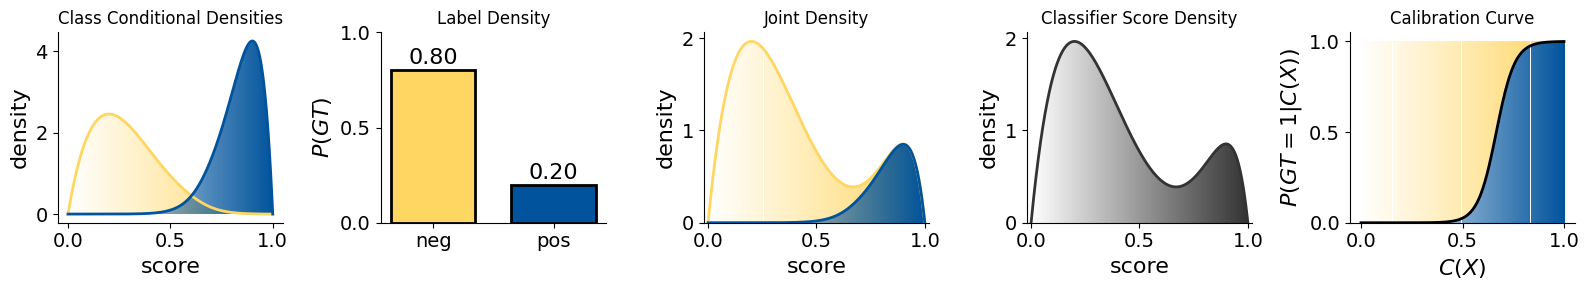

In [13]:
extrinsic_joint_distribution.plot_five_distributions(num_bin=1000)

### Generate synthetic items

In [14]:
import numpy as np
from pyquantifier.data import Item, Dataset

all_labels = ['pos', 'neg']
all_genders = ['female', 'male']
all_ages = ['young', 'old']

# Generate 10000 items which pos scores follow the mixture distribution
mix_rv = MixtureCUD(components=[beta(10, 2), beta(2, 5)], weights=[2, 8])
simulated_pos_scores = mix_rv.generate_data(10000)

calibration_curve = PlattScaling()
w = 21.92
b = -14.61
calibration_curve.set_params(w, b)

items = []
gt_label_dict = {}
for idx, pos_score in enumerate(simulated_pos_scores):
    item = Item(uid=idx+1, labels=all_labels, probs=[pos_score, 1-pos_score], gender=np.random.choice(all_genders), age=np.random.choice(all_ages))
    items.append(item)

    calibrated_pos_score = calibration_curve.get_calibrated_prob(pos_score)[0]
    gt_label_dict[item.uid] = np.random.choice(all_labels, p=[calibrated_pos_score, 1-calibrated_pos_score])

dataset = Dataset(items=items, labels=all_labels)
dataset.df.shape


  uid  pos  neg  gender    age
0  p1  0.2  0.8  female  young
1  p2  0.3  0.7  female    old
2  p3  0.9  0.1    male    old


(10000, 5)

In [15]:
gt_label_dict[1]

'neg'

In [16]:
dataset.df.columns.tolist()

['uid', 'pos', 'neg', 'gender', 'age']

In [17]:
dataset.df.head(5)

,uid,pos,neg,gender,age
0,1,0.189963,0.810037,male,young
1,2,0.59905,0.40095,female,old
2,3,0.616691,0.383309,female,old
3,4,0.53472,0.46528,male,old
4,5,0.298951,0.701049,male,old


In [18]:
# randomly sample a subset of items for annotation
sampled_dataset = dataset.select_sample_for_annotation(n=2000, strategy='neyman')

In [19]:
annotated_labels = [gt_label_dict[uid] for uid in sampled_dataset.df['uid'].values.tolist()]

In [20]:
sampled_dataset.annotate_sample(annotated_labels)

In [21]:
sampled_dataset.df.head(5)

uid       pos       neg  gender    age gt_label
bin                                                       
0   7246  7247  0.069778  0.930222  female    old      neg
    8706  8707   0.05734   0.94266  female  young      neg
    9130  9131   0.09136   0.90864  female  young      neg
    5896  5897  0.097377  0.902623    male  young      neg
    6262  6263  0.028861  0.971139  female    old      neg

In [22]:
empirical_jd = sampled_dataset.profile_dataset()

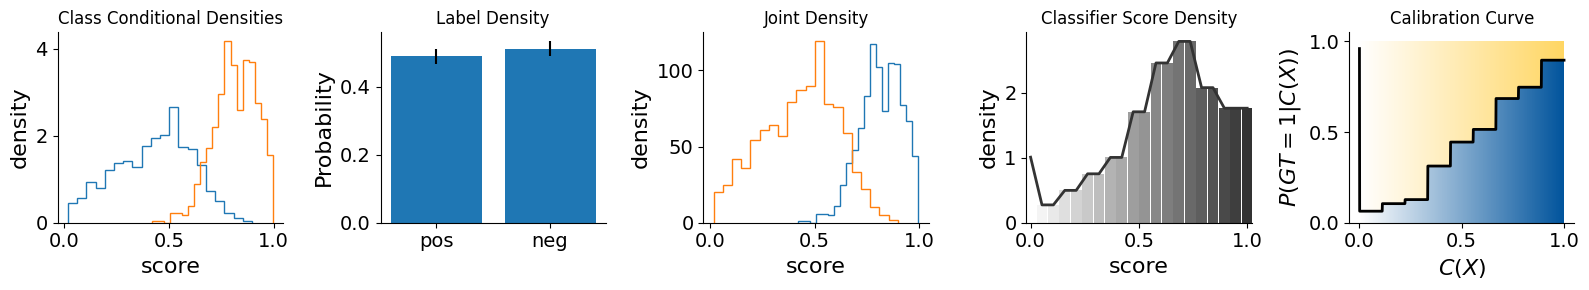

In [23]:
empirical_jd.plot_five_distributions(num_bin=20)

In [24]:
theoretical_jd = sampled_dataset.infer_joint_density()

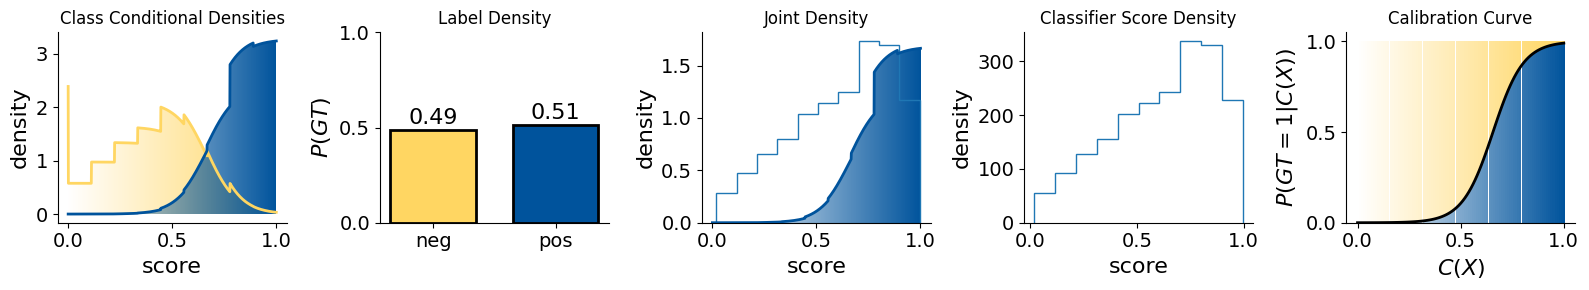

In [25]:
theoretical_jd.plot_five_distributions(num_bin=10)

# Load HOT labeling data

In [26]:
import pandas as pd
from collections import Counter

In [27]:
uid_list = []
pos_list = []
neg_list = []
gt_label_list = []
uid = 1

label_map = {True: 'pos', False: 'neg'}
with open('new_labeled_hot_data.json', 'r') as fin:
    for line in fin:
        comment_json = json.loads(line.rstrip())
        toxicity = comment_json['new_toxicity']
        toxic_label = label_map[Counter([x for x, y in comment_json['composite_toxic']]).most_common(1)[0][0]]
        uid_list.append(uid)
        pos_list.append(toxicity)
        neg_list.append(1-toxicity)
        gt_label_list.append(toxic_label)
        uid += 1

hot_df = pd.DataFrame.from_dict({'uid': uid_list, 'pos': pos_list, 'neg': neg_list, 'gt_label': gt_label_list})

all_labels = ['pos', 'neg']
hot_dataset = Dataset(df=hot_df, labels=all_labels)

In [28]:
hot_dataset.df.head(5)

,uid,pos,neg,gt_label
0,1,0.130411,0.869589,neg
1,2,0.628937,0.371063,pos
2,3,0.474732,0.525268,neg
3,4,0.153798,0.846202,neg
4,5,0.035692,0.964308,neg


In [30]:
empirical_jd = hot_dataset.profile_dataset()

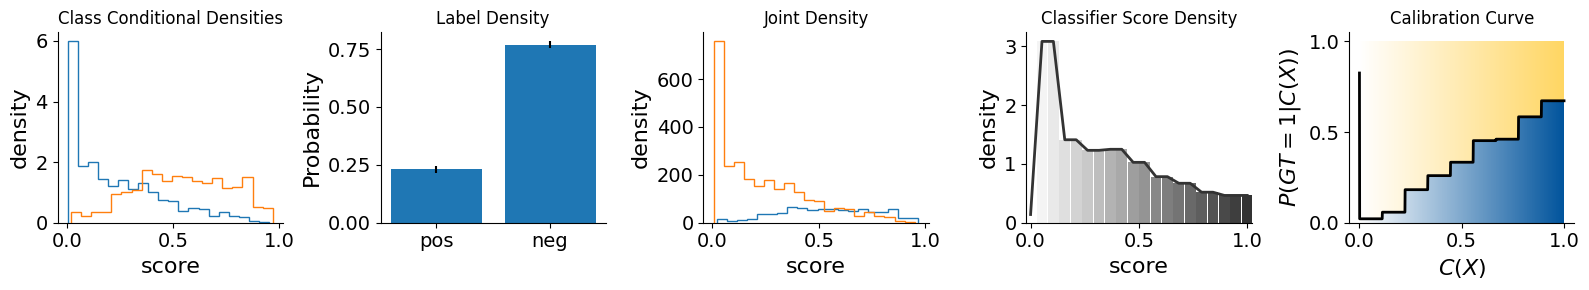

In [31]:
empirical_jd.plot_five_distributions(num_bin=20)

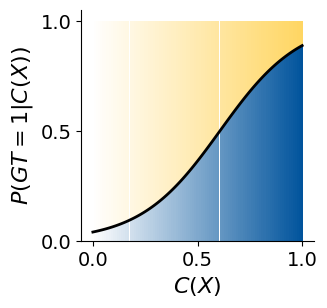

In [32]:
hot_dataset.generate_calibration_curve().plot()

In [33]:
theoretical_jd = hot_dataset.infer_joint_density()

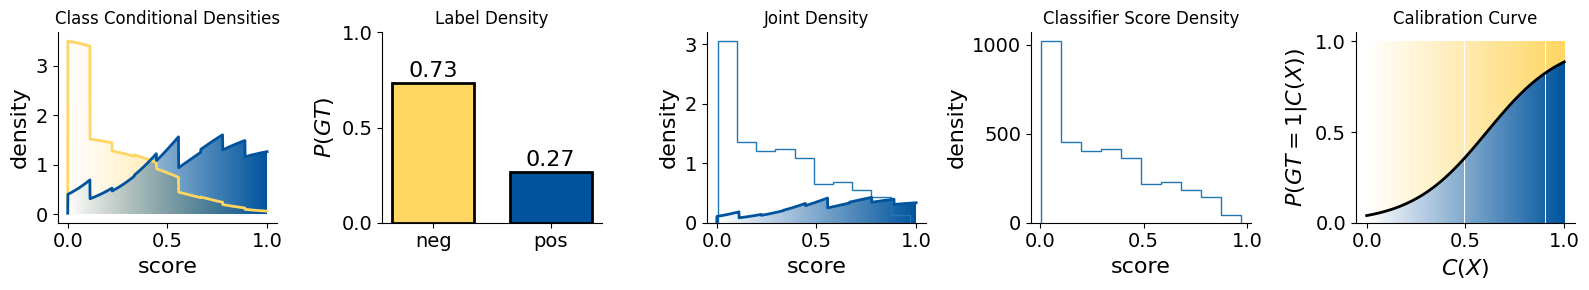

In [34]:
theoretical_jd.plot_five_distributions(num_bin=10)

In [35]:
est = hot_dataset.extrinsic_estimate(calibration_curve=hot_dataset.generate_calibration_curve(method='platt scaling'))
print(f'use platt scaling: {est} on the same dataset')

use platt scaling: 0.2306808151240033 on the same dataset


## Apply to a new dataset

In [38]:
# create a new data
new_dataset = hot_dataset.sample(n=10000, replace=True)
new_dataset.df.drop(columns=['gt_label', 'cali_pos'], inplace=True)

In [39]:
new_dataset.df.head(5)

,uid,pos,neg
3417,3418,0.528117,0.471883
726,727,0.592154,0.407846
2117,2118,0.112023,0.887977
1094,1095,0.015331,0.984669
1638,1639,0.016587,0.983413


In [40]:
# if not using calibration curve
new_dataset.df['pos'].mean()

0.30142295841276

(array([[[[5.25274164]]]]), array([[-3.19200416]]))

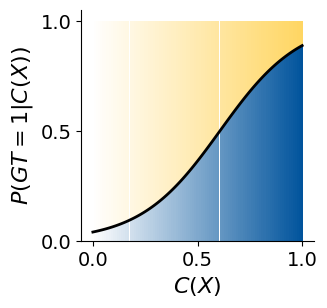

In [41]:
previous_calibration_curve = hot_dataset.generate_calibration_curve(method='platt scaling')
previous_calibration_curve.plot()
previous_calibration_curve.get_params()

In [42]:
est = new_dataset.extrinsic_estimate(calibration_curve=previous_calibration_curve)
print(f'extrinsic estimated prevalence: {est:.4f}')

extrinsic estimated prevalence: 0.2282


In [43]:
est2 = new_dataset.instrinsic_estimate(class_conditional_densities=hot_dataset.infer_class_conditional_densities())
print(f'instrinsic estimated prevalence: {est2:.4f}')

instrinsic estimated prevalence: 0.1900


In [ ]:
from collections import defaultdict, Counter
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
from sklearn.linear_model import LogisticRegression

from pyquantifier.plot import *
from pyquantifier.conf import *
from pyquantifier.distribution.mixture_distribution import MixtureDistribution

## Intrinsic Labels $GT \rightarrow \mathcal{X}$

### If the data generating process is $GT \rightarrow \mathcal{X}$

Data generating process:
- For any GT positive items, their uncalibrated classifier scores $P(UC(X)|GT=1)$ follow a Beta distribution $Beta(\alpha_p, \beta_p)$. If $\alpha_p > \beta_p$, the distribution is left skewed.
- For any GT negative items, their uncalibrated classifier scores $P(UC(X)|GT=0)$ follow a Beta distribution $Beta(\alpha_n, \beta_n)$. If $\alpha_n < \beta_n$, the distribution is right skewed.

Random variable that we allow it to change between base and target period:
- Prevalence of GT positive items, $P(GT=1)$

Statistics that we can derive from the above parameters:
- Joint distribution between $UC(X)$ and $GT$, $JD(UC(X), GT)$
- Observed classifier score distribution, $P(UC(X))$
- Probability calibration curve, $P(CC(X)|UC(X))$

## Explaining with the sentiment analysis task

Crowdsourced labeling task: Given this tweet, do you think the writer is happy or not?
Prevalence estimation task: Estimating the fraction of positive tweets in a dataset

Data generating process:
- $\alpha_p=10, \beta_p=2$. For any GT positive tweets, their classifier scores $P(UC(X)|GT=1)$ follow a Beta distribution $Beta(10, 2)$.
- $\alpha_n=2, \beta_n=5$. For any GT negative tweets, their classifier scores $P(UC(X)|GT=0)$ follow a Beta distribution $Beta(2, 5)$.

Random variable that we allow it to change between base and target period:
- Prevalence of GT positive tweets. Assume that each person only posts one tweet. 
    * In the base period, the fraction of happy Twitter users is 20%, $p_p=0.2$. 
    * At the target period, the fraction of happy Twitter users is 70%, $p_p=0.7$. 

Statistics that we can generate from the above parameters:
- Joint distribution between $UC(X)$ and $GT$, $JD(UC(X), GT)$
- Observed classifier score distribution, $P(UC(X))$
- Probability calibration curve, $P(CC(X)|UC(X))$

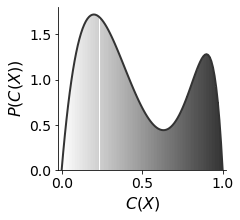

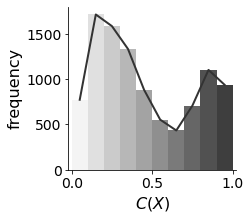

In [ ]:
mixture_distribution_rv = MixtureDistribution([stats.beta(10, 2), stats.beta(2, 5)], weights=[0.3, 0.7])
mixture_distribution_rv.plot_pdf()
mixture_distribution_rv.plot_hist(size=10000, color=ColorPalette.unknown_color)

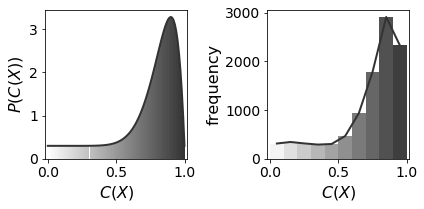

In [ ]:
mixture_distribution_rv = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.7, 0.3])

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.ravel()
    
mixture_distribution_rv.plot_pdf(ax=axes[0], color=ColorPalette.unknown_color)
mixture_distribution_rv.plot_hist(size=10000, ax=axes[1], color=ColorPalette.unknown_color)

plt.tight_layout()

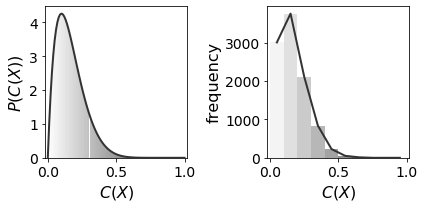

In [ ]:
single_distribution_rv = MixtureDistribution([stats.beta(2, 10)], weights=[1])

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes = axes.ravel()
    
single_distribution_rv.plot_pdf(ax=axes[0], color=ColorPalette.unknown_color)
single_distribution_rv.plot_hist(size=10000, ax=axes[1], color=ColorPalette.unknown_color)

plt.tight_layout()

## Instrinsic Label Generating Process $GT \rightarrow \mathcal{X}$

In [ ]:
from pyquantifier.distribution.class_conditional_density import ParametricConditionalDensities

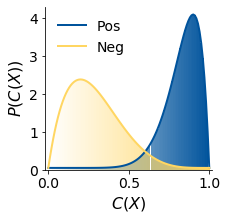

In [ ]:
good_pos_density = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_neg_density = MixtureDistribution([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_class_conditional_densities = ParametricConditionalDensities([good_pos_density, good_neg_density], ['Pos', 'Neg'])

good_class_conditional_densities.plot_pdf()

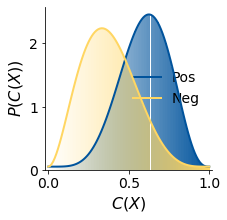

In [ ]:
bad_pos_density = MixtureDistribution([stats.beta(6, 4), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_neg_density = MixtureDistribution([stats.beta(3, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_class_conditional_densities = ParametricConditionalDensities([bad_pos_density, bad_neg_density], ['Pos', 'Neg'])

bad_class_conditional_densities.plot_pdf()

In [ ]:
from pyquantifier.distribution.label_density import ParametricLabelDensity

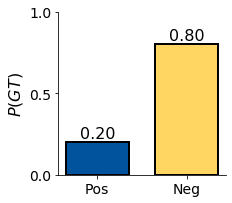

In [ ]:
label_density1 = ParametricLabelDensity([0.2, 0.8], ['Pos', 'Neg'])

label_density1.plot_bar()

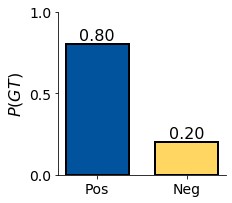

In [ ]:
label_density2 = ParametricLabelDensity([8, 2], ['Pos', 'Neg'])

label_density2.plot_bar()

In [ ]:
from pyquantifier.distribution.joint_density import ParametricJointDensity1

In [ ]:
# GT -> x data simulation configuration
class_names = ['Pos', 'Neg']

good_pos_density = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_neg_density = MixtureDistribution([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_class_conditional_densities = ParametricConditionalDensities([good_pos_density, good_neg_density], class_names)

label_density1 = ParametricLabelDensity([0.2, 0.8], class_names)

parametric_joint_distribution1 = ParametricJointDensity1(label_density1, good_class_conditional_densities)
sampled_data_points1 = parametric_joint_distribution1.rvs(size=10000)

print(f'sampled {len(sampled_data_points1)} data points from the joint distribution')
print(sampled_data_points1[:10])

sampled 10000 data points from the joint distribution
[(0.7543959952766598, 'Pos'), (0.7965580580098841, 'Pos'), (0.9369852279751224, 'Pos'), (0.9204135974057842, 'Pos'), (0.8178181983116973, 'Pos'), (0.8185884630430601, 'Pos'), (0.8852181638984504, 'Pos'), (0.7913619266374011, 'Pos'), (0.7208245615896814, 'Pos'), (0.8776393895051063, 'Pos')]


In [ ]:
from pyquantifier.distribution.joint_density import EmpiricalJointDistribution

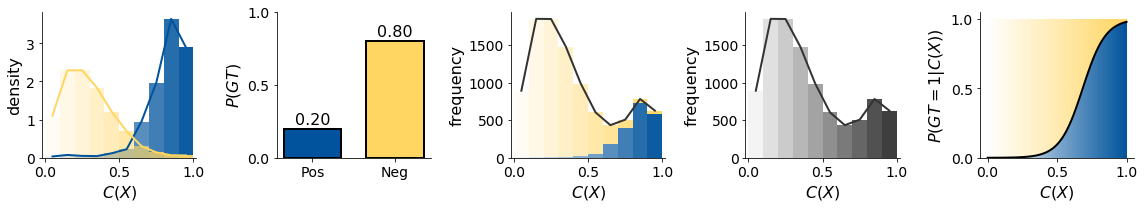

In [ ]:
empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points1)

empirical_joint_distribution.visualize_all_distribution()

We need a family tree of different modeling assumptions for the joint distribution

- Joint distribution (joint distribution between a continuous variable (cx) and a discrete variable (label))
-- get_density(cx, label)
-- 

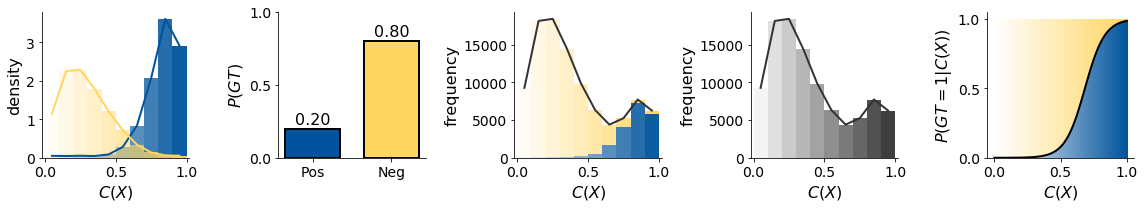

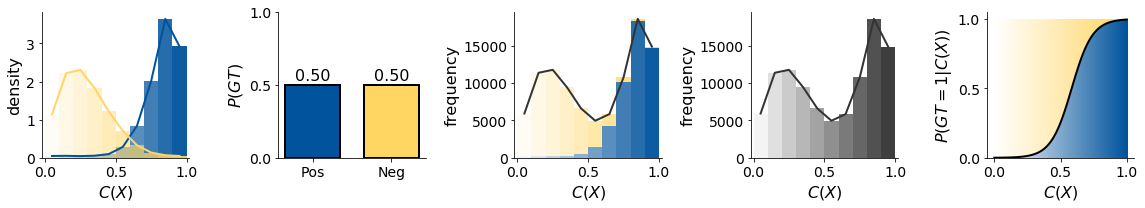

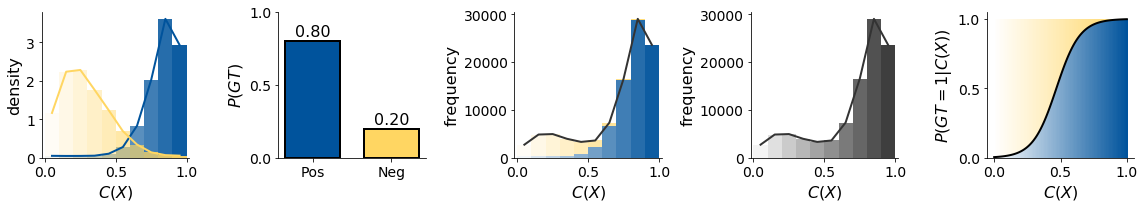

In [ ]:
class_names = ['Pos', 'Neg']
num_sample = 100000

good_pos_density = MixtureDistribution([stats.beta(10, 2), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_neg_density = MixtureDistribution([stats.beta(2, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
good_class_conditional_densities = ParametricConditionalDensities([good_pos_density, good_neg_density], class_names)

for pos_prevalence in [0.2, 0.5, 0.8]:
    label_density = ParametricLabelDensity([pos_prevalence, 1 - pos_prevalence], class_names)

    parametric_joint_distribution = ParametricJointDensity1(label_density, good_class_conditional_densities)
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

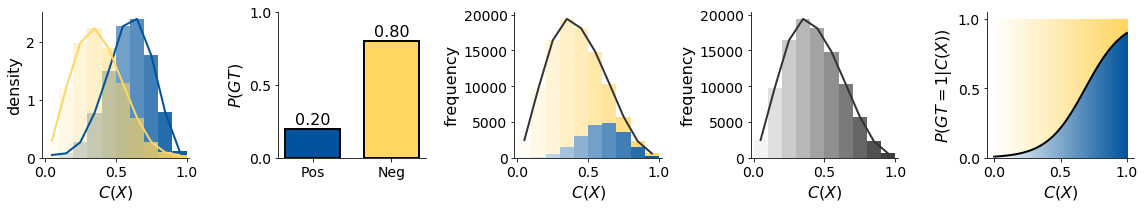

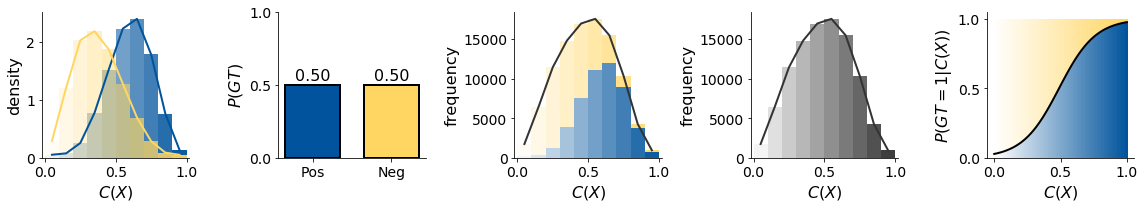

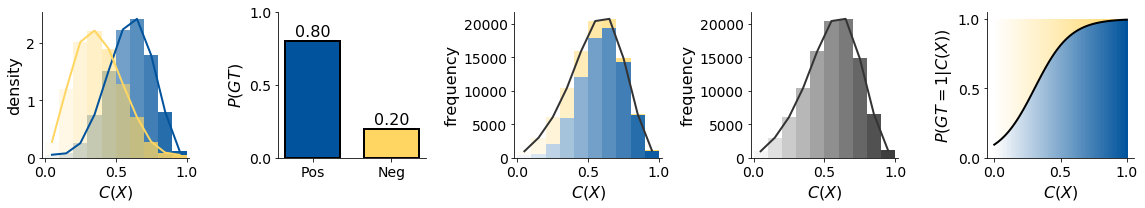

In [ ]:
class_names = ['Pos', 'Neg']
num_sample = 100000

bad_pos_density = MixtureDistribution([stats.beta(6, 4), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_neg_density = MixtureDistribution([stats.beta(3, 5), stats.uniform(0, 1)], weights=[0.95, 0.05])
bad_class_conditional_densities = ParametricConditionalDensities([bad_pos_density, bad_neg_density], class_names)

for pos_prevalence in [0.2, 0.5, 0.8]:
    label_density = ParametricLabelDensity([pos_prevalence, 1 - pos_prevalence], class_names)

    parametric_joint_distribution = ParametricJointDensity1(label_density, bad_class_conditional_densities)
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

## Extrinsic Label Generating Process $\mathcal{X} \rightarrow GT$

In [ ]:
from pyquantifier.distribution.classifier_density import ParametricClassifierDensity

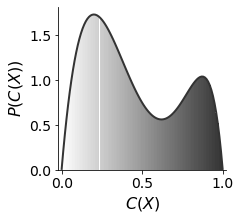

In [ ]:
any_density = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                  weights=[0.29, 0.7, 0.01])

any_classifier_density = ParametricClassifierDensity(any_density)

any_classifier_density.plot_pdf()

In [ ]:
from pyquantifier.distribution.calibration_curve import ParametricPlattScaling

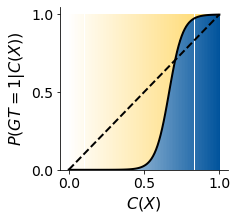

In [ ]:
w = 21.92
b = -14.61

good_calibration_curve = ParametricPlattScaling()
good_calibration_curve.set_params(w, b)

good_calibration_curve.plot_line(show_diagonal=True)

In [ ]:
from pyquantifier.distribution.joint_density import ParametricJointDensity2

In [ ]:
# x -> GT data simulation configuration

w = 21.92
b = -14.61

good_calibration_curve = ParametricPlattScaling()
good_calibration_curve.set_params(w, b)

any_density = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                  weights=[0.29, 0.7, 0.01])

any_classifier_density = ParametricClassifierDensity(any_density)

parametric_joint_distribution2 = ParametricJointDensity2(good_calibration_curve, any_density)
sampled_data_points2 = parametric_joint_distribution2.rvs(size=10000)

print(f'sampled {len(sampled_data_points2)} data points from the joint distribution')
print(sampled_data_points2[:10])

sampled 10000 data points from the joint distribution
[(0.47195693791195975, 'Neg'), (0.04736667172630213, 'Neg'), (0.8716723339848846, 'Pos'), (0.012999178275242636, 'Neg'), (0.03587333972651055, 'Neg'), (0.16797008294382437, 'Neg'), (0.26585856000076874, 'Neg'), (0.5460838732000706, 'Neg'), (0.8391551923880073, 'Neg'), (0.4854623130451082, 'Neg')]


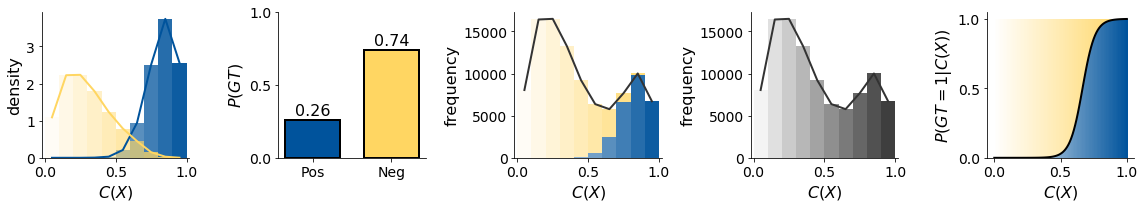

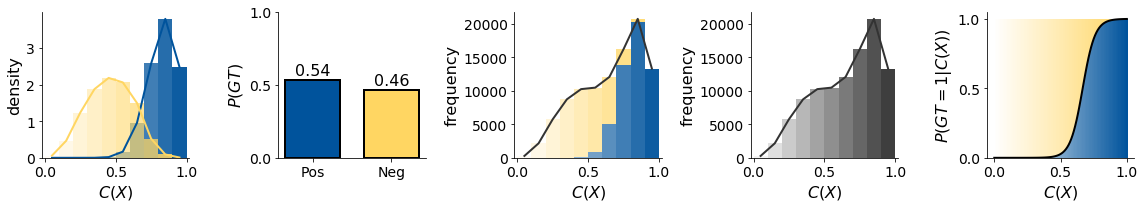

In [ ]:
num_sample = 100000

w = 21.92
b = -14.61

good_calibration_curve = ParametricPlattScaling()
good_calibration_curve.set_params(w, b)

any_density1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                   weights=[0.29, 0.7, 0.01])
any_density2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
                                   weights=[0.59, 0.4, 0.01])

for any_density in [any_density1, any_density2]:
    any_classifier_density = ParametricClassifierDensity(any_density)

    parametric_joint_distribution = ParametricJointDensity2(good_calibration_curve, any_density)
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

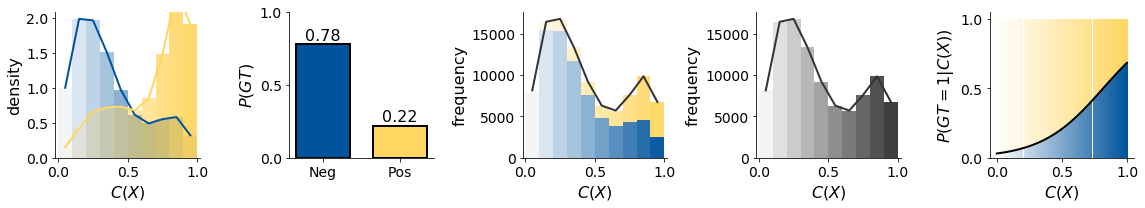

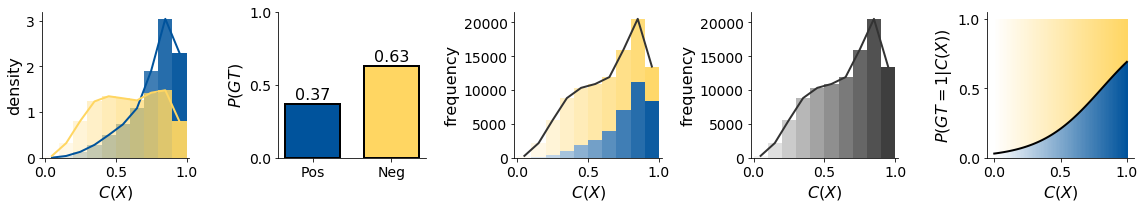

In [ ]:
num_sample = 100000

w = 4.26
b = -3.46

bad_calibration_curve = ParametricPlattScaling()
bad_calibration_curve.set_params(w, b)

any_density1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)],
                                   weights=[0.29, 0.7, 0.01])
any_density2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
                                   weights=[0.59, 0.4, 0.01])

for any_density in [any_density1, any_density2]:
    any_classifier_density = ParametricClassifierDensity(any_density)

    parametric_joint_distribution = ParametricJointDensity2(bad_calibration_curve, any_density)
    
    sampled_data_points = parametric_joint_distribution.rvs(size=num_sample)

    empirical_joint_distribution = EmpiricalJointDistribution(sampled_data_points)

    empirical_joint_distribution.visualize_all_distribution()

In [ ]:
# # this plot is generated by simulation parameters: pos_gt_density and neg_gt_density
# # positive and negative density function
# def extrinsic_label_data_generator(prob_cali_func, 
#                                    all_cxs_list, 
#                                    period_list=['base', 'target'],
#                                    name='X to GT simulated data'):
#     """
#     This is a funcation that...
      
#     Attributes:
#         a_pos: alpha value of the Beta distribution for the GT positive items
#         b_pos: beta value of the Beta distribution for the GT positive items
#     """
    
#     # canvas configurations
#     num_period = len(period_list)
#     fig, axes = plt.subplots(1 + num_period, 5, figsize=(16, 3 + 3 * num_period))
    
#     # first row: plot the parametric calibration curve function
#     prob_cali_curve = prob_cali_func.get_calibrated_prob(fine_axis)
#     prob_cali_curve_w, prob_cali_curve_b = prob_cali_func.get_params()
#     prob_cali_func.plot_line(ax=axes[0, 0])
    
#     for row_idx, (all_cxs, period) in enumerate(zip(all_cxs_list, period_list)):        
#         row_idx += 1
        
#         all_ccxs = prob_cali_func.get_calibrated_prob(all_cxs)
        
#         all_labeled_data = []

#         for cx, ccx in zip(all_cxs, all_ccxs):
#             gt = random.choices([0, 1], [1-ccx, ccx])[0]
#             if gt:
#                 all_labeled_data.append((cx, 'Pos'))
#             else:
#                 all_labeled_data.append((cx, 'Neg'))
                
#         all_labels = [label for _, label in all_labeled_data]
        
#         # class-conditional density plot
#         class_conditional_density_obj = ClassConditionalDensities(all_labeled_data)
#         class_conditional_density_obj.plot_hist(ax=axes[row_idx, 0])

#         # label density plot
#         label_density_obj = LabelDensity(all_labels)
#         label_density_obj.plot_bar(ax=axes[row_idx, 1])
        
#         # joint distribution plot
#         joint_distribution_obj = JointDensity(all_labeled_data)
#         joint_distribution_obj.plot_hist(ax=axes[row_idx, 2])
        
#         # classifier density plot
#         classifier_density_obj = ClassifierDensity(all_cxs)
#         classifier_density_obj.plot_hist(ax=axes[row_idx, 3])

#         # calibration curve plot
#         calibration_curve_obj = PlattScaling()
#         calibration_curve_obj.fit(all_labeled_data)
#         calibration_curve_obj.plot_line(ax=axes[row_idx, 4])


#     for col_idx in [1, 2, 3, 4]:
#         axes[0, col_idx].set_axis_off()

#     for ax in axes.ravel():
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.tick_params(axis='both', which='major', labelsize=14)

#     plt.tight_layout()

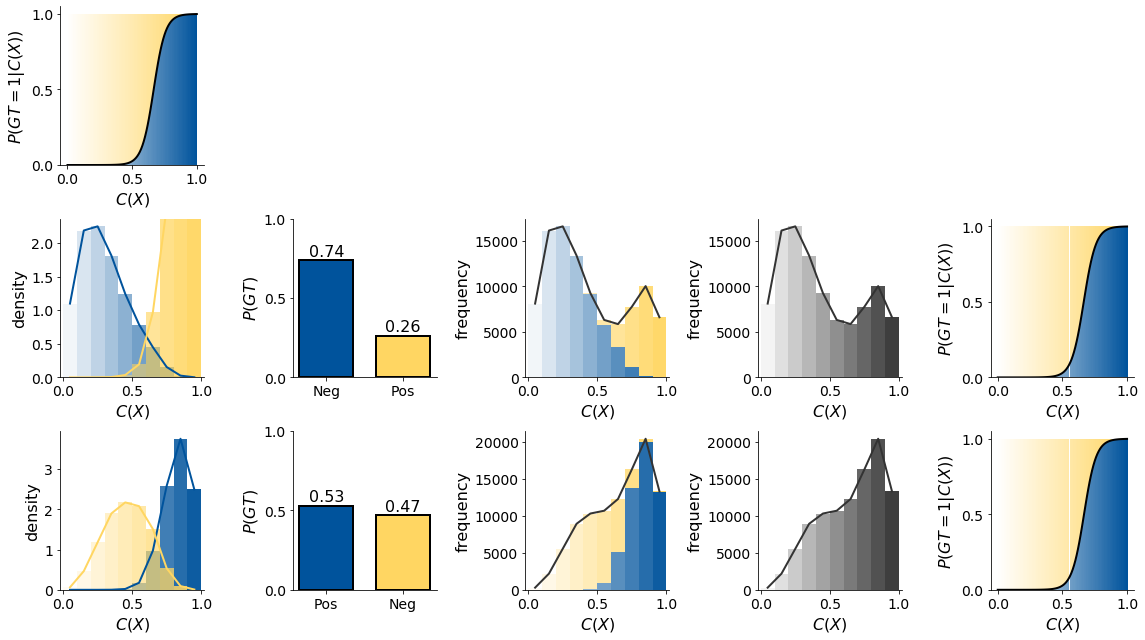

In [ ]:
# # GT -> x data simulation configuration
# w = 21.92
# b = -14.61

# good_lr_regressor = PlattScaling()
# good_lr_regressor.set_params(w, b)

# any_density_rvs1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)], 
#                                 weights=[0.29, 0.7, 0.01])

# any_density_rvs2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
#                                 weights=[0.59, 0.4, 0.01])

# extrinsic_label_data_generator(good_lr_regressor, 
#                                [any_density_rvs1.rvs(100000), any_density_rvs2.rvs(100000)],
#                                period_list=['base', 'target'],
#                                name='datasetnn2')

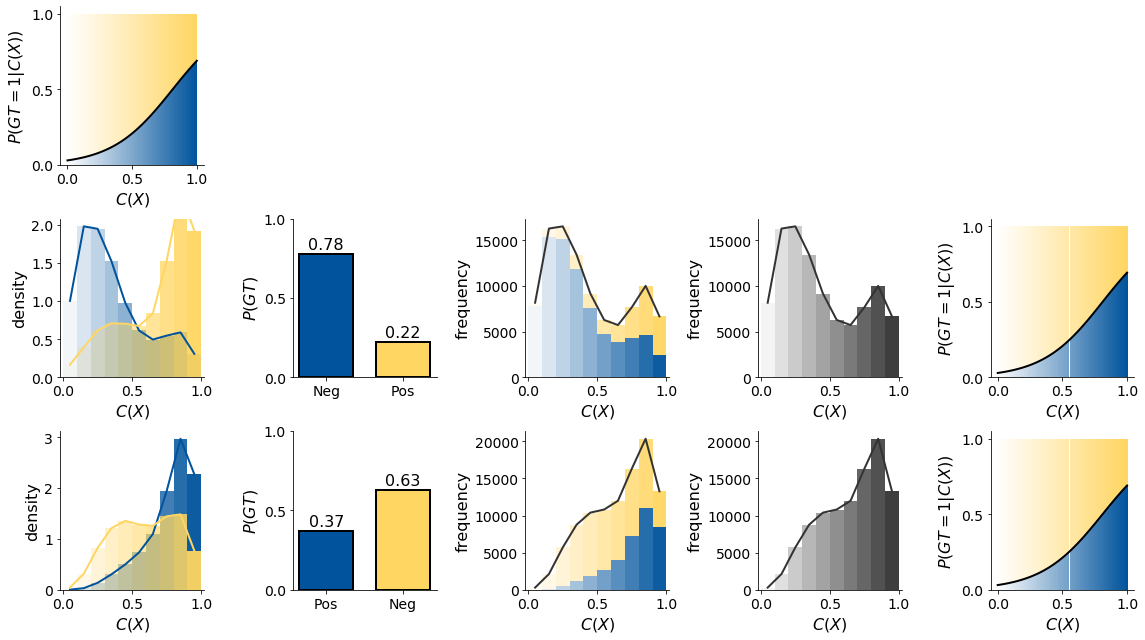

In [ ]:
# # GT -> x data simulation configuration
# w = 4.26
# b = -3.46

# bad_lr_regressor = PlattScaling()
# bad_lr_regressor.set_params(w, b)

# any_density_rvs1 = MixtureDistribution([stats.beta(8, 2), stats.beta(2, 5), stats.uniform(0, 1)], 
#                                 weights=[0.29, 0.7, 0.01])

# any_density_rvs2 = MixtureDistribution([stats.beta(8, 2), stats.beta(4, 5), stats.uniform(0, 1)], 
#                                 weights=[0.59, 0.4, 0.01])

# extrinsic_label_data_generator(bad_lr_regressor, 
#                                [any_density_rvs1.rvs(100000), any_density_rvs2.rvs(100000)],
#                                period_list=['base', 'target'],
#                                name='datasetnn2')

In [ ]:
#         # data output module
#         uc_x_array = np.concatenate((pos_draws, neg_draws))
#         gt_list = [True] * num_pos + [False] * num_neg

#         url_array = np.random.choice(['yes', 'no'], size)
#         lang_array = np.random.choice(['en', 'es'], size)

#         output_df = pd.DataFrame(data={'has_url': url_array,
#                                        'lang': lang_array,
#                                        'C(X)': uc_x_array, 
#                                        'GT': gt_list})
#         output_df = output_df.sample(frac=1).reset_index(drop=True)
#         output_df.to_csv(f'../data/{name}_{period}.csv', sep=',', index=False)

In [ ]:
# def intrinsic_label_data_generator(positive_rvs, negative_rvs, 
#                                    p_p_list=[0.2, 0.7], 
#                                    size_list=[100000, 100000], 
#                                    period_list=['base', 'target'],
#                                    name='GT to X simulated data'):
#     """
#     This is a funcation that...
      
#     Attributes:
#         a_pos: alpha value of the Beta distribution for the GT positive items
#         b_pos: beta value of the Beta distribution for the GT positive items
#     """
    
#     # canvas configurations
#     num_period = len(p_p_list)
#     fig, axes = plt.subplots(1 + num_period, 5, figsize=(16, 3 + 3 * num_period))

#     # first row: plot the parametric class-conditional density function
#     color1, color2 = ColorPalette.CC2
#     positive_rvs.plot_pdf(ax=axes[0, 0], color=color1, label=f'$P(C(X)|GT=1)$')
#     negative_rvs.plot_pdf(ax=axes[0, 0], color=color2, label=f'$P(C(X)|GT=0)$')

#     axes[0, 0].set_ylabel('$P(C(X)|GT)$')
#     axes[0, 0].set_yticks([])
#     axes[0, 0].legend(frameon=False)
    
#     for row_idx, (p_p, size, period) in enumerate(zip(p_p_list, size_list, period_list)):
#         row_idx += 1

#         p_n = 1 - p_p
#         num_pos = int(size * p_p)
#         num_neg = size - num_pos
        
#         pos_draws = positive_rvs.rvs(num_pos)
#         neg_draws = negative_rvs.rvs(num_neg)
#         all_labeled_data = [(cx, 'Pos') for cx in pos_draws] + [(cx, 'Neg') for cx in neg_draws]
#         all_cxs = [cx for cx, _ in all_labeled_data]
#         all_labels = [label for _, label in all_labeled_data]

#         # class-conditional density plot
#         class_conditional_density_obj = ClassConditionalDensities(all_labeled_data)
#         class_conditional_density_obj.plot_hist(ax=axes[row_idx, 0])

#         # label density plot
#         label_density_obj = LabelDensity(all_labels)
#         label_density_obj.plot_bar(ax=axes[row_idx, 1])
        
#         # joint distribution plot
#         joint_distribution_obj = JointDensity(all_labeled_data)
#         joint_distribution_obj.plot_hist(ax=axes[row_idx, 2])
        
#         # classifier density plot
#         classifier_density_obj = ClassifierDensity(all_cxs)
#         classifier_density_obj.plot_hist(ax=axes[row_idx, 3])

#         # calibration curve plot
#         calibration_curve_obj = PlattScaling()
#         calibration_curve_obj.fit(all_labeled_data)
#         calibration_curve_obj.plot_line(ax=axes[row_idx, 4])


#     for col_idx in [1, 2, 3, 4]:
#         axes[0, col_idx].set_axis_off()

#     for ax in axes.ravel():
#         ax.spines['right'].set_visible(False)
#         ax.spines['top'].set_visible(False)
#         ax.tick_params(axis='both', which='major')

#     plt.tight_layout()